# Exercise 2: Labeling

Exercise based on Chapter 3 of the book *Advances in Financial Machine Learning* by Marcos Lopez de Prado.

In this exercise we will familiarize ourselves with the Triple-Barrier method, as well as different ways of measuring market volatility.

In [136]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

pd.options.mode.chained_assignment = None

Let's start by reading the dollar bar data we sampled in the first exercise. This week it is once again convenient to work with DateTime indices.

In [137]:
df = pd.read_csv('./data/dollar_bars.csv', parse_dates=['datetime'], index_col='datetime')

Since the timestamps in our data only have a granularity up to the second, we might have several bars with the same DateTime. This week we require unique indeces, so let's drop duplicates.

In [138]:
print(f'Proportion of duplicate TimeStamps: {df.index.duplicated().sum() / df.size}')
df = df[~df.index.duplicated()]
df.head()

Proportion of duplicate TimeStamps: 0.012153979383373623


,price,volume,dollar_volume
datetime,,,
2010-01-03 17:00:00,1113.2,1.0,1113.2
2010-01-03 17:01:20,1114.3,2.0,2228.6
2010-01-03 17:04:29,1114.6,1.0,1114.6
2010-01-03 17:06:31,1114.9,14.0,15608.6
2010-01-03 17:16:21,1116.0,1.0,1116.0


In [139]:

# Convert index to datetime if it's not already
df.index = pd.to_datetime(df.index, errors='coerce')

# Check if the index is now a DatetimeIndex
print(type(df.index))  # Should show: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>

# Filter the data for the year 2011
df_2011 = df[df.index.year == 2011]
print(df_2011.head())  # Print first few rows for verification


<class 'pandas.core.indexes.datetimes.DatetimeIndex'>
                      price  volume  dollar_volume
datetime                                          
2011-01-02 17:00:15  1256.3     5.0         6281.5
2011-01-02 17:00:55  1256.7     2.0         2513.4
2011-01-02 17:46:48  1256.8     1.0         1256.8
2011-01-02 19:21:56  1257.0     1.0         1257.0
2011-01-02 19:26:19  1257.0     1.0         1257.0


In [140]:
# You can work with a subset of the data if computations are taking too long
df = df.loc['2011']

<Axes: xlabel='Date', ylabel='Price'>

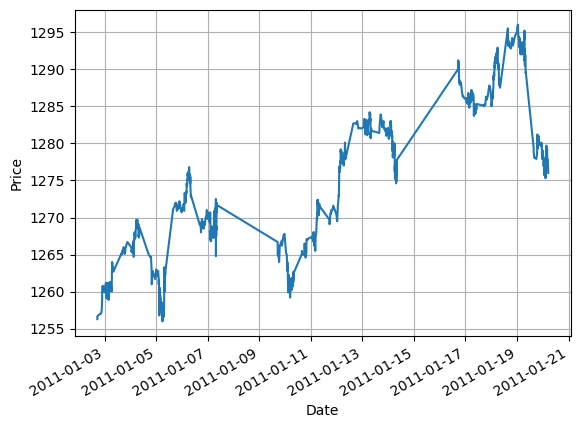

In [141]:
df[df.index.year == 2011].plot(y='price', ylabel='Price', xlabel='Date', legend=False, grid=True)

## Volatility estimation

In order to perform labeling using the triple-barrier method we must define limits for profit-taking and loss-stopping. In practice it is desirable to define these as a function of market risk, rather than keeping them fixed (see De Prado 3.2). To this end we will calculate the daily volatility (standard deviation of daily *logarithmic* returns) for each bar.

In [142]:
def getDailyReturns(close):
    index = close.index
    values = close.values
       
    df0 = index.searchsorted(index - pd.Timedelta(days=1))
    df0 = df0[df0 > 0]
    
    prev_index = index[df0 - 1]
    curr_index = index[close.shape[0] - df0.shape[0]:]
    
    df0 = np.log(close.loc[curr_index] / close.loc[prev_index].values )
    return df0

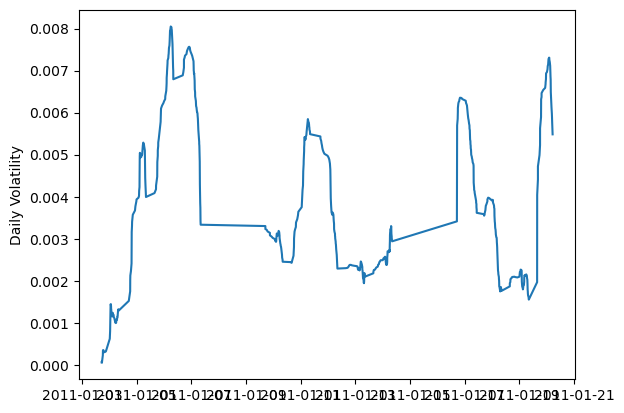

In [143]:
vol = getDailyReturns(df['price']).ewm(span=100).std()
plt.plot(vol)
plt.ylabel('Daily Volatility')
plt.show()

In [144]:
df = df.loc[vol.dropna().index].assign(vol=vol.dropna())
df.head()

,price,volume,dollar_volume,vol
datetime,,,,
2011-01-03 17:21:55,1265.9,1.0,1265.9,0.000056
2011-01-03 17:24:18,1266.0,2.0,2532.0,0.000079
2011-01-03 17:26:06,1266.0,1.0,1266.0,0.000075
2011-01-03 17:26:09,1266.0,1.0,1266.0,0.000070
2011-01-03 17:35:40,1266.0,1.0,1266.0,0.000065


### <u>Task 1</u>

In the code above we calculated the moving standard deviation using an exponentially weighted window, whereby more recent observations are given more weight. Perform the same calculation using a standard rolling window and plot the resulting series in the same figure as the result of the exponentially weighted calculation. What differences do you spot between the series? Why might you prefer one method over the other?

The following documentation of windowing operations might be helpful:<br>
https://pandas.pydata.org/docs/user_guide/window.html#rolling-window

In [145]:
def mad(x):
    return np.median(np.fabs(x - np.median(x)))

### <u>Task 2</u>

When calculating the volatility using a standard rolling window we can also apply a custom function (see the section Rolling Apply in the linked documentation). Perform the volatility calculation using the median absolute deviation (MAD) provided above. Plot the results.

How do the results differ from before? Why might MAD be a desirable metric, especially in the context of financial timeseries?

**NB: In Pandas MAD refers to mean absolute deviation. This is not what we want to use.**

## Positions

Make sure to use the initial volatility estimate moving forward. Next we will filter down our data to those timestamps, where we wish to place a bet. These ideally correspond to events that cause shifts in the market. For our purposes we will do this using the symmetric CUSUM filter. For information see De Prado 2.5.2.

In [146]:
def getTEvents(gRaw, h):
    tEvents_mask = np.zeros(len(gRaw), dtype=bool)
    sPos, sNeg = 0.0, 0.0
    diff = np.diff(np.log(gRaw))
    for i, value in enumerate(diff, start=1):
        sPos = max(0.0, sPos + value)
        sNeg = min(0.0, sNeg + value)
        if sNeg < -h:
            sNeg = 0.0
            tEvents_mask[i] = True
        elif sPos > h:
            sPos = 0.0
            tEvents_mask[i] = True
    tEvents = gRaw.index[tEvents_mask]
    #
    return tEvents

In [147]:
position_starts = getTEvents(df['price'], df['vol'].std())
pd.Series(position_starts).head()

0   2011-01-04 03:30:41
1   2011-01-04 05:27:18
2   2011-01-04 17:08:42
3   2011-01-04 19:34:37
4   2011-01-05 02:35:16
Name: datetime, dtype: datetime64[ns]

In [148]:
df_ = pd.read_csv('./data/dollar_bars.csv', parse_dates=['datetime'], index_col='datetime')

In the triple-barrier method place a vertical barrier that represents a time-limit for our position. Let us utlizie a length of one day, meaning each position will be closed after one day, at the latest.

In [149]:
#def vertical_barrier(close, tEvents, numDays):
#    # SNIPPET 3.4 ADDING A VERTICAL BARRIER
#    t1=close.index.searchsorted(tEvents+pd.Timedelta(days=numDays))
 #   t1=t1[t1<close.shape[0]]
#    t1=pd.Series(close.index[t1],index=tEvents[:t1.shape[0]]) # NaNs at end
    
#    return t1

In [150]:
def vertical_barrier(close, tEvents, numDays):
    # Ensure tEvents is a DatetimeIndex, allow inference of format (including milliseconds)
    tEvents = pd.to_datetime(tEvents, errors='coerce', format=None)  # No format specified, auto-detect
    print(f'Updated tEvents type: {type(tEvents)}')
    print(tEvents[:5])  # Check the first few values of tEvents
    
    # Ensure close.index is a DatetimeIndex (convert if needed)
    if not isinstance(close.index, pd.DatetimeIndex):
        close.index = pd.to_datetime(close.index, errors='coerce')
    
    print(f'close.index type: {type(close.index)}')
    print(close.index[:5])  # Check first few values of close.index
    
    # Adding a vertical barrier
    t1 = close.index.searchsorted(tEvents + pd.Timedelta(days=numDays))
    
    # Filter t1 to make sure it’s within the bounds of the close data
    t1 = t1[t1 < close.shape[0]]
    
    # Create a Series with the corresponding times, matching the length of tEvents
    t1 = pd.Series(close.index[t1], index=tEvents[:t1.shape[0]])  # NaNs at the end if mismatch
    
    return t1


In [151]:
position_times = vertical_barrier(df_['price'], position_starts, 1)
position_times.head()

Updated tEvents type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2011-01-04 03:30:41', '2011-01-04 05:27:18',
               '2011-01-04 17:08:42', '2011-01-04 19:34:37',
               '2011-01-05 02:35:16'],
              dtype='datetime64[ns]', name='datetime', freq=None)
close.index type: <class 'pandas.core.indexes.datetimes.DatetimeIndex'>
DatetimeIndex(['2010-01-03 17:00:00', '2010-01-03 17:00:00',
               '2010-01-03 17:01:20', '2010-01-03 17:04:29',
               '2010-01-03 17:06:31'],
              dtype='datetime64[ns]', name='datetime', freq=None)


datetime
2011-01-04 03:30:41   2011-01-05 03:45:13
2011-01-04 05:27:18   2011-01-05 05:30:48
2011-01-04 17:08:42   2011-01-05 18:05:30
2011-01-04 19:34:37   2011-01-05 20:07:27
2011-01-05 02:35:16   2011-01-06 02:39:29
Name: datetime, dtype: datetime64[ns]

Let's collect out data for each of the positions in a DataFrame.

In [152]:
df2 = pd.DataFrame(position_times)
df2 = df2.rename_axis('index')
df2 = df2.reset_index(drop=False)
df2 = df2.rename({'index': 'position_start', 'datetime': 'position_end'}, axis=1)
df2.head()

,position_start,position_end
0,2011-01-04 03:30:41,2011-01-05 03:45:13
1,2011-01-04 05:27:18,2011-01-05 05:30:48
2,2011-01-04 17:08:42,2011-01-05 18:05:30
3,2011-01-04 19:34:37,2011-01-05 20:07:27
4,2011-01-05 02:35:16,2011-01-06 02:39:29


## Horizontal barriers

Next, we will define an upper and a lower barrier for each of our positions. The upper barrier corresponds to a profit-taking limit, whereby we close the position if the price rises above the barrier. Similarly, the lower barrier represents a loss-stopping limit.

We will initially define our barriers such that the upper barriers corresponds to a positive return equal to the daily volatility estimate. The lower barrier will correspond to a equally sized negative return. Notice that this configuration results in barriers that are symmetric around the initial price.

In [153]:
df2['profit_return_lim'] = df['vol'].loc[df2['position_start']].reset_index(drop=True)
df2['loss_return_lim'] = -df2['profit_return_lim']
df2.head()

,position_start,position_end,profit_return_lim,loss_return_lim
0,2011-01-04 03:30:41,2011-01-05 03:45:13,0.001197,-0.001197
1,2011-01-04 05:27:18,2011-01-05 05:30:48,0.001005,-0.001005
2,2011-01-04 17:08:42,2011-01-05 18:05:30,0.001521,-0.001521
3,2011-01-04 19:34:37,2011-01-05 20:07:27,0.002616,-0.002616
4,2011-01-05 02:35:16,2011-01-06 02:39:29,0.004286,-0.004286


## Labeling

We can now run the triple barrier method for each of our positions. This will label each position as 1 (upper barrier touched first), -1 (lower barrier touched first) or 0 (vertical barrier touched first).

In [154]:
import numpy as np

def triple_barrier(prices, position):
    start = position['position_start']
    end = position['position_end']
    profit = position['profit_return_lim']
    loss = position['loss_return_lim']
    
    df = prices.loc[start:end]['price']
    prices_arr = df.values
    
    profit_price = (1 + profit) * prices_arr[0]
    loss_price = (1 + loss) * prices_arr[0]
    
    profit_indices = np.where(prices_arr > profit_price)[0]
    loss_indices = np.where(prices_arr < loss_price)[0]
    
    profit_time = end + pd.Timedelta(days=1) if len(profit_indices) == 0 else df.index[profit_indices[0]]
    loss_time = end + pd.Timedelta(days=1) if len(loss_indices) == 0 else df.index[loss_indices[0]]
    
    time, label = min([(profit_time, 1), (end, 0), (loss_time, -1)])
    
    return time, label

In [155]:
df2[['touch_time','label']] = df2.apply(lambda x: triple_barrier(df, x), axis=1, result_type='expand')
df2.head()

,position_start,position_end,profit_return_lim,loss_return_lim,touch_time,label
0,2011-01-04 03:30:41,2011-01-05 03:45:13,0.001197,-0.001197,2011-01-04 05:04:48,1
1,2011-01-04 05:27:18,2011-01-05 05:30:48,0.001005,-0.001005,2011-01-04 07:20:39,-1
2,2011-01-04 17:08:42,2011-01-05 18:05:30,0.001521,-0.001521,2011-01-04 19:34:37,-1
3,2011-01-04 19:34:37,2011-01-05 20:07:27,0.002616,-0.002616,2011-01-05 02:42:33,-1
4,2011-01-05 02:35:16,2011-01-06 02:39:29,0.004286,-0.004286,2011-01-05 15:41:37,1


We can also inspect the distribution of labels.

In [156]:
df2['label'].value_counts()

label
 1    35
-1    25
 0    22
Name: count, dtype: int64

Let's save the data for later use.

In [157]:
save = True
if save:
    df2.to_csv('./data/labeled_positions.csv')

### <u>Task 3, 5 credit version of the course</u>

Play around with the upper and lower barriers. Start by keeping them symmetric and varying the width. Note down how this affects the distribution of labels. Then repeat the experiment a couple times with nonsymmetric labels.

Analyze the results. Are all the results in line with your expectations? Why or why not? How do the different barrier configurations reflect a traders attitude in regards to risk?